## Progression of selfplay games
Scores are mean log score
* Games 0 to 200: Fixed move order L,U,D,R
* Games 200 to xx: `20200123/onehot_20_200_c128b5_p20_bs2048lr0.01d0.0_s2_best`

In [1]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
os.chdir('../selfplay/')

In [2]:
def get_max(x):
    tiles = []
    for _ in range(16):
        tiles.append(x & 0xF)
        x >>= 4
    return max(tiles)

In [3]:
indices = []
moves = []
scores = []
tiles = []
move_dir = []
i = 0
while True:
    try:
        x = np.load('fixed/fixed'+str(i).zfill(5)+'.npz')
        indices.append(i)
        moves.append(len(x['boards']))
        scores.append(x['score'])
        tiles.append(get_max(x['boards'][-1].item()))
        move_dir.append(np.argsort(x['results'], axis=1)[:, -1])
        i += 1
    except FileNotFoundError:
        print('Got {} fixed games'.format(i))
        break
        
i_fixed = i
i = 0
while True:
    try:
        x = np.load('convnet0123/'+str(i).zfill(5)+'.npz')
        indices.append(i+i_fixed)
        moves.append(len(x['boards']))
        scores.append(x['score'])
        tiles.append(get_max(x['boards'][-1].item()))
        move_dir.append(np.argsort(x['results'], axis=1)[:, -1])
        i += 1
    except FileNotFoundError:
        print('Got {} convnet0123 games'.format(i))
        break

Got 200 fixed games
Got 10 convnet0123 games


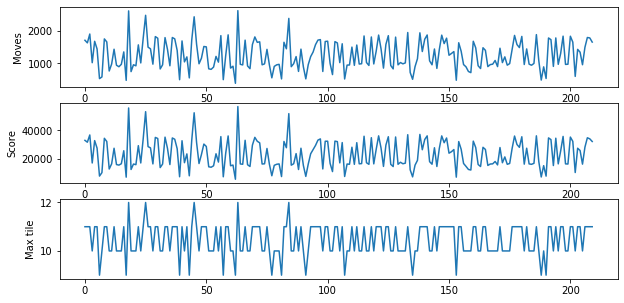

In [4]:
plt.subplots(figsize=(10, 5))
plt.subplot(311)
plt.plot(indices, moves)
plt.ylabel('Moves')
plt.subplot(312)
plt.plot(indices, scores)
plt.ylabel('Score')
plt.subplot(313)
plt.plot(indices, tiles)
plt.ylabel('Max tile')
plt.show()

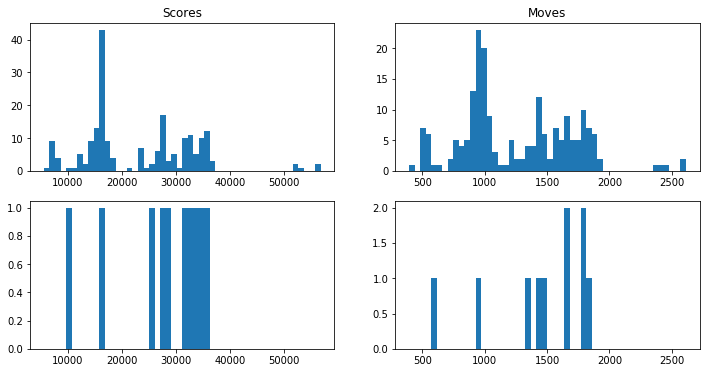

In [5]:
xscore = (min(scores), max(scores))
xmoves = (min(moves), max(moves))
plt.figure(figsize=(12,6))
for i, j in zip(range(2), (0, 200)):
    plt.subplot(2,2,1+2*i)
    plt.hist(scores[j:j+200], range=xscore, bins=50)
    if not i: plt.title('Scores')
    plt.subplot(2,2,2+2*i)
    plt.hist(moves[j:j+200], range=xmoves, bins=50)
    if not i: plt.title('Moves')
plt.show()

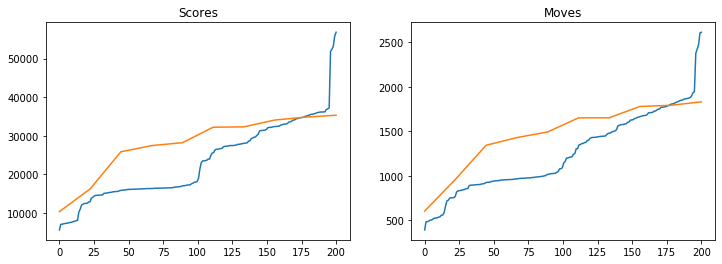

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for j in (0, 200):
    plt.plot(np.linspace(0, 200, len(moves[j:j+200])), sorted(scores[j:j+200]))
plt.title('Scores')
plt.subplot(1,2,2)
for j in (0, 200):
    plt.plot(np.linspace(0, 200, len(moves[j:j+200])), sorted(moves[j:j+200]))
plt.title('Moves')
plt.show()

In [18]:
# Test if means are the same
i = 0
print(stats.ttest_ind(scores[200*i:200*(i+1)], scores[200*(i+1):200*(i+2)], equal_var=False))
print(stats.ttest_ind(moves[200*i:200*(i+1)], moves[200*(i+1):200*(i+2)], equal_var=False))

Ttest_indResult(statistic=-1.6496508385851396, pvalue=0.1289748306267753)
Ttest_indResult(statistic=-1.5632213352780997, pvalue=0.14852338201920795)


In [20]:
# Test if samples are drawn from the same distribution
i = 0
print(stats.ks_2samp(scores[200*i:200*(i+1)], scores[200*(i+1):200*(i+2)]))
print(stats.ks_2samp(moves[200*i:200*(i+1)], moves[200*(i+1):200*(i+2)]))

Ks_2sampResult(statistic=0.36, pvalue=0.13422568504989296)
Ks_2sampResult(statistic=0.355, pvalue=0.14450186372621154)


In [21]:
# Test if variances are the same
i = 0
print(stats.bartlett(scores[200*i:200*(i+1)], scores[200*(i+1):200*(i+2)]))
print(stats.bartlett(moves[200*i:200*(i+1)], moves[200*(i+1):200*(i+2)]))

BartlettResult(statistic=0.5271208603226627, pvalue=0.46781983104777236)
BartlettResult(statistic=0.22651180152623468, pvalue=0.6341224247840642)


# Move distribution

In [23]:
import pandas as pd
import seaborn as sns

In [24]:
sns_moves = pd.DataFrame(columns=['group','Left','Up','Right','Down'])
groups = ['Fixed']*200 + ['ConvNet']*200
for m, g in zip(move_dir, groups):
    hist = np.histogram(m, bins=np.arange(5), density=True)[0]
    sns_moves = sns_moves.append({'group': g,
                                  'Left': hist[0],
                                  'Up': hist[1],
                                  'Right': hist[2],
                                  'Down': hist[3]},
                                  ignore_index=True)

In [25]:
sns_moves = pd.melt(sns_moves, id_vars='group', var_name='move', value_name='percent')

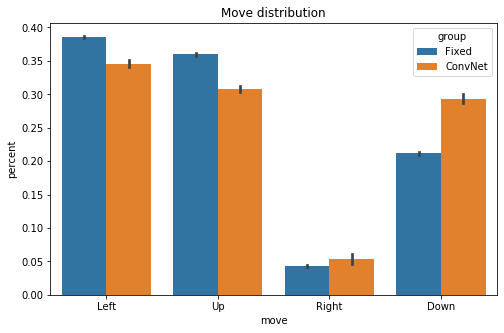

In [26]:
# Note: seaborn error bars are 95% CI of mean
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='move', y='percent', hue='group', data=sns_moves)
ax.set_title('Move distribution')
plt.show()

Network has much higher down move ratio, almost approaching upmove. Ideal strategy might be something like L, U/D, R